<a href="https://colab.research.google.com/github/rpasquini/urban-econometrics/blob/master/Experimentos_Aleatorizados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
import statsmodels.api as sm  
from scipy import stats  
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [66]:
df=pd.read_csv('https://raw.githubusercontent.com/rpasquini/econometrics_and_causality/master/happiness_on_tap_extract.csv')

Extracto de datos de: 

[Devoto, F., Duflo, E., Dupas, P., Parienté, W., & Pons, V. (2012). Happiness on tap: piped water adoption in urban Morocco. American Economic Journal: Economic Policy, 4(4), 68-99.](https://web.stanford.edu/~pdupas/MoroccoWaterConnections.pdf
)

Las variables fueron modificadas para el proposito de este ejercicio. 

**Descripción de variables**


motivacion: Dummy = 1 si el hogar recibió motivación para conexión \
conectado: Dummy = 1 si el hogar se conectó a la red de agua \
sexojefe: Dummy = 1 Masculino, 0 Femenino \
edadjefe: Edad Jefe de Hogar \
jefesabeleer: Dummy=1 Jefe sabe leer \
jefesabeescribir: Dummy=1 Jefe sabe escribir \
pdiasfueaescuela: Porcentaje dias hijos fueron a la escuela.




In [51]:
df.head()

,random_id,motivacion,conectado,sexojefe,edadjefe,jefesabeleer,jefesabeescribir,pdiasfueaescuela
0,1,0,0,1,37.0,1.0,1.0,NaN
1,3,1,1,1,45.0,0.0,0.0,57.142860
2,5,0,0,1,50.0,1.0,1.0,85.714287
3,7,1,1,1,54.0,1.0,1.0,85.714287
4,8,0,0,2,66.0,0.0,0.0,NaN


In [71]:
df.groupby('motivacion').count()

,random_id,conectado,sexojefe,edadjefe,jefesabeleer,jefesabeescribir,pdiasfueaescuela
motivacion,,,,,,,
0,377,377,377,372,372,372,147
1,411,411,411,407,404,404,173


In [52]:
df=df.dropna()

In [53]:
dias_tratados=df.pdiasfueaescuela.loc[df.motivacion==1]
dias_control=df.pdiasfueaescuela.loc[df.motivacion==0]

## Test de medias (supuesto varianzas son iguales)



In [54]:
stats.ttest_ind(dias_tratados, dias_control, equal_var=True)

Ttest_indResult(statistic=-1.5002574789125818, pvalue=0.13454932763122404)

#Equivalencia del test a través de estimar OLS 



$pdiasescuela_i=\beta_0+\beta_1motivacion_i+\epsilon_i$

In [55]:
def ols(lista, data):
  """ 
  Funcion que realiza la regresion OLS
  La primera variable de la lista es la dependiente, el resto son las explicativas
  data es la base de datos
  """
  datos=data[lista]
  # el metodo dropna() me permite eliminar las filas que tienen algun valor missing
  datos=datos.dropna()
  Y=datos[lista[0]]
  X=datos[lista[1:]]
  X=sm.add_constant(X)
  modelo=sm.OLS(Y,X)
  modeloajustado=modelo.fit()
  print(modeloajustado.summary())
  return modeloajustado

In [56]:
ols(['pdiasfueaescuela', 'motivacion'], df)

                            OLS Regression Results                            
Dep. Variable:       pdiasfueaescuela   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.251
Date:                Thu, 30 Jul 2020   Prob (F-statistic):              0.135
Time:                        21:32:20   Log-Likelihood:                -1476.3
No. Observations:                 317   AIC:                             2957.
Df Residuals:                     315   BIC:                             2964.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.1331      2.116     29.366      0.0

# Randomnization Inference Approach


In [64]:
lista=[["Buenos Aires",1,1],["Catamarca",1,1],["Chaco",1,1],["Chubut",1,1],["Córdoba",1,0],["Corrientes",0,0],["Entre Ríos",0,0],["Formosa",0,0],["Jujuy",0,0],["La Pampa",0,0]]
variables=['provincia',"T","Y"]
df=pd.DataFrame(lista, columns=variables)

In [58]:
df

,provincia,T,Y
0,Buenos Aires,1,1
1,Catamarca,1,1
2,Chaco,1,1
3,Chubut,1,1
4,Córdoba,1,0
5,Corrientes,0,0
6,Entre Ríos,0,0
7,Formosa,0,0
8,Jujuy,0,0
9,La Pampa,0,0


In [65]:
  Y_tratadas=df['Y'].loc[df['T']==1]
  Y_control=df['Y'].loc[df['T']==0]
  dif_means=np.mean(Y_tratadas)-np.mean(Y_control) #computamos la diferencia de medias
  dif_means

0.8

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81ea032198>]],
      dtype=object)

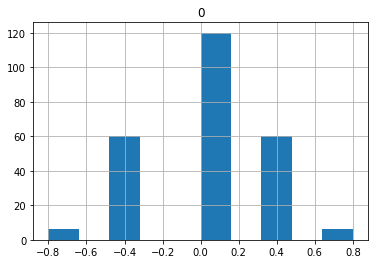

In [59]:
from itertools import permutations 
import numpy as np
iteradorcomb=combinations(df.index,5)  #Generamos un iterador de permutaciones. Cada vez que invoquemos la funcion next() sobre él me devolverá una iteracion.
listadediferencias=[]
for i in range(0,252):
  posicionestratadosfalso=next(iteradorcomb)
  df.loc[df.index.isin(posicionestratadosfalso),'falsotratamiento']=1
  df.loc[~df.index.isin(posicionestratadosfalso),'falsotratamiento']=0
  Y_tratadas=df['Y'].loc[df['falsotratamiento']==1]
  Y_control=df['Y'].loc[df['falsotratamiento']==0]
  dif_means=np.mean(Y_tratadas)-np.mean(Y_control) #computamos la diferencia de medias
  listadediferencias.append(dif_means)

pd.DataFrame(listadediferencias).hist()

In [60]:
stats.percentileofscore(listadediferencias,0.8)

99.0079365079365